## Constraining Models of Massive Gravity Using the NANOGrav 15-Year Data Set

To reproduce our code, we start with importing all of the relevant python packages. We will import as we need them. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.integrate import odeint

### Fig. 1

We generate Fig. 1 from the paper. 

We first define variables and functions we will be using.

In [3]:
# Define the parameters
H_inf = 1
a_r = 1 
tau_r = 1/(a_r*H_inf)
k = 1
tau_m = 6*tau_r  # tau_m will be before matter-rad equality, but after inflation ends https://arxiv.org/pdf/1808.02381.pdf
tau_end = 3*tau_m
m = .8*H_inf
nu = np.sqrt(9/4 - m**2 / H_inf**2)
N = 5000
tau_init = -200*tau_r # the value that we start the plot at
tau = np.linspace(tau_init, tau_end, N)
N_neg_r = 0
N_pos_r = 0
N_m = 0
isReal = False

for val in tau:
    if val <= -tau_r:
        N_neg_r += 1
    if val <= tau_r:
        N_pos_r += 1
    if val <= tau_m:
        N_m += 1

def scale_fac(conf_time):
    if conf_time < tau_r:
        return -1/(H_inf*conf_time)
    else:
        return a_r * conf_time / tau_r


def d_scale_fac_dz(conf_time):
    if conf_time < tau_r:
        return -2/(H_inf*conf_time**3)
    else:
        return 0


def mu(conf_time):
    if conf_time < tau_m:
        return m
    else:
        return 0


# The input for the homogeneous version of EoM: chi''(u) + 2/u chi'(u) + chi(u) = 0
def M_derivs_homo(M, u):
    return [M[1], -(k**2 + (scale_fac(u)*mu(u))**2 - d_scale_fac_dz(u) / scale_fac(u)) * M[0]]

/home/user/.local/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:242: ComplexWarning: Casting complex values to real discards the imaginary part
  output = _odepack.odeint(func, y0, t, args, Dfun, col_deriv, ml, mu,


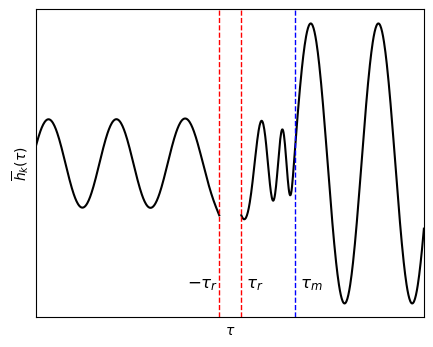

In [4]:
fig, (ax1) = plt.subplots(1, figsize=(5, 4))


# We use the central difference method
xxx = np.array([tau[0] - 0.0000001, tau[0] + 0.0000001])
xx = (np.sqrt(-np.pi*xxx) / 2 * scipy.special.hankel1(nu, -k*xxx))[:2]
xx = xx[1] - xx[0]
xx /= xxx[1] - xxx[0]

# Get the homogeneous solution using scipy.integrate.odeint, and we case on whether it is real or imaginary
if isReal:
    v_0 = np.sqrt(-np.pi*tau[0]) / 2 * \
        scipy.special.hankel1(nu, -k*tau[0])
    v_prime_0 = xx
else:
    v_0 = np.sqrt(-np.pi*tau[0]) / 2 * \
        scipy.special.hankel1(nu, -k*tau[0]).imag
    v_prime_0 = xx.imag


v, v_prime = odeint(M_derivs_homo, [v_0, v_prime_0], tau[0:N_neg_r]).T


ax1.plot(
    tau[0:N_neg_r], v, label=r"Numerical solution", color="black"
)

v_0_rest = v[N_neg_r-1]
xxxxx = np.array([tau[N_neg_r-1] - 0.0000001, tau[N_neg_r-1] + 0.0000001])
if isReal:
    xxxx = (np.sqrt(-np.pi*xxxxx) / 2 *
            scipy.special.hankel1(nu, -k*xxxxx))[:2]
else:
    xxxx = -1j*(np.sqrt(-np.pi*xxxxx) / 2 *
                scipy.special.hankel1(nu, -k*xxxxx))[:2]
xxxx = xxxx[1] - xxxx[0]
xxxx /= xxxxx[1] - xxxxx[0]
v_prime_0_rest = xxxx
v_rest, v_prime_rest = odeint(
    M_derivs_homo, [v_0_rest, v_prime_0_rest], tau[N_pos_r:]).T


ax1.plot(
    tau[N_pos_r:], v_rest, color="black"
)

ax1.set_xlabel(r"$\tau$")

ax1.set_xlim(-tau_end, tau_end)
ax1.set_ylabel(r"$\overline{h}_k(\tau)$")


plt.axvline(x=-tau_r, color='red', linestyle='dashed',
            linewidth=1)
plt.axvline(x=tau_r, color='red', linestyle='dashed',
            linewidth=1, label=r'$\pm \tau_r$')
plt.axvline(x=tau_m, color='blue', linestyle='dashed',
            linewidth=1, label=r'$\tau_m$')
plt.text(-tau_r-3, -2, r'$-\tau_r$',size=12)
plt.text(tau_r+.5, -2, r'$\tau_r$', size=12)
plt.text(tau_m+.5, -2, r'$\tau_m$',size=12)

plt.xticks([])
plt.yticks([])

plt.legend().set_visible(False)
plt.savefig("figs/fig1.pdf")
plt.show()


### Fig. 2 

In order to generate figure 2, which consists of three 3-dimensional contour plots, we import some more packages and define some more variables and functions. 

In [8]:
import matplotlib.ticker as mticker
import math

In [11]:
T = 6.58e-25
L = 1.97e-16
m2Gpc = 3.1e25

c_g = 1 
hbar = 6.582119569e-25  # GeV / Hz
c = 3e8 # m / s
omega_M = .3111
omega_R = 9.182e-5
omega_L = .6889

h = .6766 # according to Planck 2018 TT, TE, EE + lowE + lensing + BAO data
H_0 = 100*h*3.2404407e-20 # in Hz 
M_GW = H_0*1e10
a_0 = 1.

eta_0 = np.sqrt(4/(H_0**2*omega_M))
tau_r = 5.494456683825391e-7  # calculated from equation (19)

def hz2gpc(hz): 
    return hz*(T/L)*m2Gpc
def gpc2hz(gpc): 
    return gpc*(1/m2Gpc)*L/T

def P_T_prim(k):
    n_T = 0
    # from page 3 of https://arxiv.org/pdf/1407.4785.pdf
    k_ref = gpc2hz(0.01*1e3)
    r = .2
    P_gamma_k_ref = 2.2e-9  # also from same page in same paper
    A_T_at_k_ref = r*P_gamma_k_ref
    return A_T_at_k_ref*(k/k_ref)**n_T


def T_1_sq(x):
    return 1+1.57*x+3.42*x**2


def T_2_sq(x):
    return 1/(1-.22*x**1.5+.65*x**2)


def T_3_sq(x):
    return 1+.59*x+.65*x**2


def g_star_T_in(k, g_0):
    g_max = 106.75
    A = (-1 - 10.75/g_0)/(-1+10.75/g_0)
    B = (-1 - g_max/10.75)/(-1+g_max/10.75)
    return g_0*((A+np.tanh(-2.5*np.log10(k/(2*np.pi)/(2.5e-12))))/(A+1))*((B+np.tanh(-2.0*np.log10(k/(2*np.pi)/(6e-9))))/(B+1))


def spherical_bess_approx(n, x):
    return 1/(np.sqrt(2)*x)


def T_T_sq(k):
    g_star_0 = 3.36
    g_star_s_0 = 3.91
    tau_0 = eta_0/1e-3
    T_R = 1e12  # in GeV
    T_R = 1e14
    k_mpc = hz2gpc(k)/1e3
    k_eq = 7.1e-2*omega_M*h**2
    g_star_T_R = 106.75*g_star_s_0/g_star_0
    k_R = 1.7e14*(g_star_T_R/106.75)**(1/6)*(T_R/1e7)
    x_eq = k_mpc/k_eq
    x_R = k_mpc/k_R
    func_to_use = spherical_bess_approx
    extra_fac = 25 # this is to make the results identical to Fig 1 in https://arxiv.org/pdf/1808.02381.pdf
    return omega_M**2*(g_star_T_in(k, g_star_0)/g_star_0)*(g_star_s_0/g_star_T_in(k, g_star_s_0))**(4/3)*(3*(func_to_use(1, k*tau_0))/(k*tau_0))**2*T_1_sq(x_eq)*T_2_sq(x_R)*extra_fac


def P_T(k):
    return T_T_sq(k)*P_T_prim(k)


def omega_GW_massless(k):
    return 1/12*(k/(a_0*H_0))**2*P_T(k)


def omega_GW_full(f, m, hinf, tr, tm):
    nu = (9/4 - m**2 / hinf**2)**.5
    k = f*2*np.pi
    return tm/tr*(k*tr)**(3-2*nu)*omega_GW_massless(k)


def log_tick_formatter(val, pos=None):
    return f"$10^{{{int(val)}}}$"

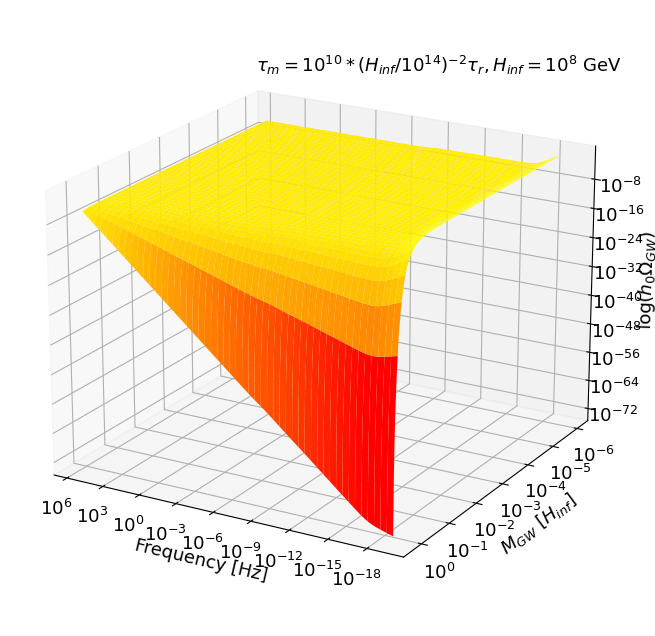

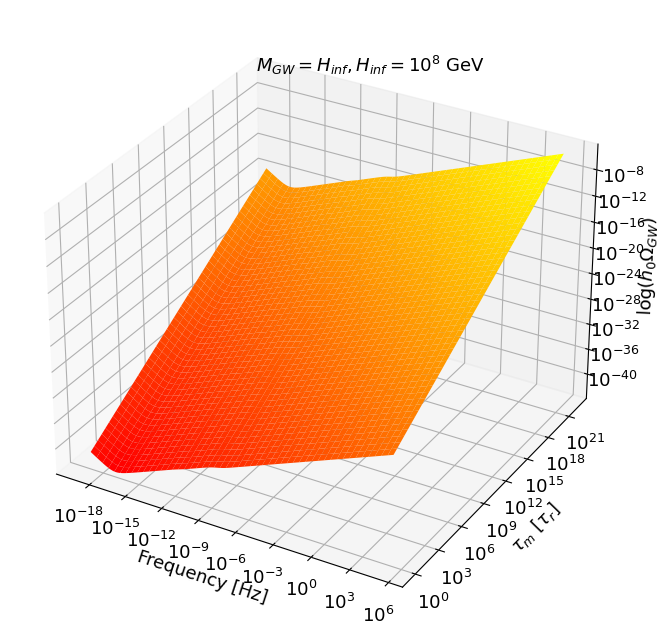

/tmp/ipykernel_1792/922577523.py:84: RuntimeWarning: invalid value encountered in sqrt
  nu = (9/4 - m**2 / hinf**2)**.5


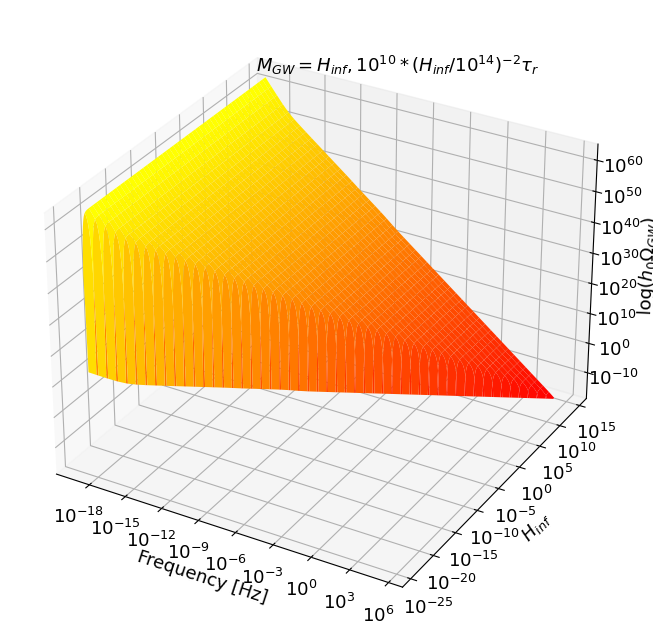

In [12]:
fs = 13
plt.rcParams.update({'font.size': fs})

N=500
num_freqs = N
H_inf = 1e8  # in GeV
f_UV = 2e8*(H_inf/1e14)**.5
tau_m = 1e10*(H_inf/1e14)**-2*tau_r

freqs = np.logspace(-19,np.log10(f_UV),num_freqs)
M_arr = np.logspace(-6,np.log10(1.5), N)*H_inf

def f(x, y):
    return omega_GW_full(x, y, H_inf, tau_r, tau_m)

X, Y = np.meshgrid(freqs, M_arr)
Z = f(X, Y)

plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
surf = ax.plot_surface( np.log10(X), np.log10(Y/H_inf), np.log10(Z),linestyles="solid", cmap='autumn')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('$M_{GW}$ [$H_{inf}$]')
ax.set_zlabel('$\log(h_0\Omega_{GW})$')

ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
ax.zaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.zaxis.set_major_locator(mticker.MaxNLocator(integer=True))


surf._edgecolors2d = surf._edgecolor3d
surf._facecolors2d = surf._facecolor3d

ax.view_init(elev=20, azim=120)
ax.annotate(r'$\tau_m = 10^{10}*(H_{inf}/10^{14})^{-2}\tau_r, H_{inf} = 10^8$ GeV', xy=(0.4,0.9),xycoords='axes fraction',
             fontsize=fs)

plt.savefig('figs/fig2a.pdf')
plt.show()

# for the second figure 

tau_m_arr = np.logspace(0,np.log10(1e10*(H_inf/1e14)**-2), N)

M_GW = H_inf

def f(x, y):
    return omega_GW_full(x, M_GW, H_inf, tau_r, y)

X, Y = np.meshgrid(freqs, tau_m_arr*tau_r)
Z = f(X, Y)

plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
surf = ax.plot_surface( np.log10(X),np.log10(Y/tau_r), np.log10(Z),linestyles="solid", cmap='autumn')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel(r'$\tau_m \ [\tau_r]$')
ax.set_zlabel('$\log(h_0\Omega_{GW})$')

ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
ax.zaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.zaxis.set_major_locator(mticker.MaxNLocator(integer=True))

surf._edgecolors2d = surf._edgecolor3d
surf._facecolors2d = surf._facecolor3d

ax.annotate(r'$M_{GW} = H_{inf}, H_{inf} = 10^8$ GeV', xy=(0.4,0.9),xycoords='axes fraction',
             fontsize=fs)

plt.savefig('figs/fig2b.pdf')
plt.show()

# for the third figure 
H_inf = np.logspace(-24,14, N) # in GeV

tau_m = 1e10*(H_inf/1e14)**-2*tau_r 
M_GW = H_inf

def f(x, y):
    return omega_GW_full(x, M_GW, y, tau_r, tau_m)

X, Y = np.meshgrid(freqs, H_inf)
Z = f(X, Y)

plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
surf = ax.plot_surface( np.log10(X),np.log10(Y), np.log10(Z),linestyles="solid", cmap='autumn')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel(r'$H_{inf}$')
ax.set_zlabel('$\log(h_0\Omega_{GW})$')

ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
ax.zaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.zaxis.set_major_locator(mticker.MaxNLocator(integer=True))

surf._edgecolors2d = surf._edgecolor3d
surf._facecolors2d = surf._facecolor3d

ax.annotate(r'$M_{GW} = H_{inf}, 10^{10}*(H_{inf}/10^{14})^{-2}\tau_r$', xy=(0.4,0.9),xycoords='axes fraction',
             fontsize=fs)

plt.savefig('figs/fig2c.pdf')

plt.show()

### Fig. 3

We now use the data from the NANOGrav 15-year data set in order to plot the following figures. 

We first download the necessary packages. The signal data is already located in the data folder.  

In [14]:
import enterprise.constants as const
import h5py
import json
from math import log10, floor

In [15]:
f_yr = 1/(365*24*3600)
gamma_cp = 3.2  # from page 4 of https://iopscience.iop.org/article/10.3847/2041-8213/acdac6/pdf
A_cp = -14.19382002601611
f_BBN = 1.5e-11 # in Hz according to 22.290 of maggiore vol 2 
N = 1000
num_freqs = 30

def powerlaw_vec(f, f_0, log10_A=A_cp, gamma=gamma_cp):
    return np.sqrt((10**log10_A)**2 / 12.0 / np.pi**2 * const.fyr**(gamma-3) * f**(-gamma) * f_0)


def powerlaw(f, log10_A=A_cp, gamma=gamma_cp):
    return np.sqrt((10**log10_A)**2 / 12.0 / np.pi**2 * const.fyr**(gamma-3) * f**(-gamma) * f[0])


def round_it(x, sig):
    if x == 0:
        return 0
    return round(x, sig-int(floor(log10(abs(x))))-1)

def omega_GW(f, A_cp, gamma):
    return 2*np.pi**2*(10**A_cp)**2*f_yr**2/(3*H_0**2)*(f/f_yr)**(5-gamma)

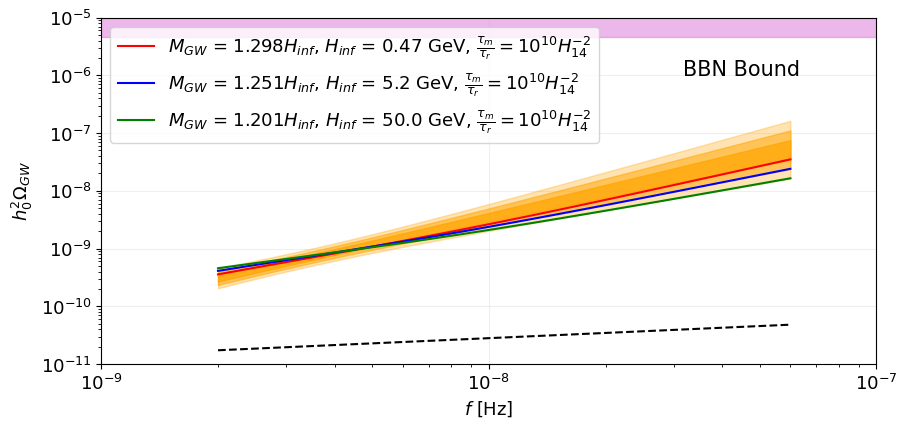

In [16]:
# You can download this yourself from the official NANOGrav release 
# https://zenodo.org/records/8067506/files/NANOGrav15yr_CW-Analysis_v1.0.0.zip
hdf_file = "data/15yr_quickCW_detection.h5"

# specify how much of the first samples to discard
burnin = 0
extra_thin = 1

with h5py.File(hdf_file, 'r') as f:
    samples_cold = f['samples_cold'][0, burnin::extra_thin, :]

# Make Figure
plt.figure(figsize=(10,4.5))

num_freqs = 30
freqs = np.logspace(np.log10(2e-9), np.log10(6e-8), num_freqs)
A_arr = samples_cold[:, -1]
gamma_arr = samples_cold[:, -2]
OMG_15 = np.zeros((67, num_freqs))

PL = np.zeros((67, num_freqs))
for ii in range(67):
    OMG_15[ii] = np.log10(h**2*omega_GW(freqs, A_arr[ii], gamma_arr[ii]))
plt.fill_between(freqs, 10**(OMG_15.mean(axis=0) - 1*OMG_15.std(axis=0)), 10**(OMG_15.mean(axis=0) + 1*OMG_15.std(axis=0)), color='orange', alpha=0.7)
plt.fill_between(freqs, 10**(OMG_15.mean(axis=0) - 2*OMG_15.std(axis=0)), 10**(OMG_15.mean(axis=0) + 2*OMG_15.std(axis=0)), color='orange', alpha=0.5)
plt.fill_between(freqs, 10**(OMG_15.mean(axis=0) - 3*OMG_15.std(axis=0)), 10**(OMG_15.mean(axis=0) + 3*OMG_15.std(axis=0)), color='orange', alpha=0.3)

plt.plot(freqs, h**2*omega_GW(freqs, -15.6, 4.7),
         linestyle='dashed', color='black')

# This part plots the energy densities of massive gravitons from the Mukohyama Blue tilted paper https://arxiv.org/pdf/1808.02381.pdf
tau_r = 5.494456683825391e-7

H_inf_arr = [.47, 5.2, 5e1]
M_arr = [1.298, 1.251, 1.201]
color_arr = ['red', 'blue', 'green']
freqs = np.logspace(np.log10(2e-9), np.log10(6e-8), num_freqs)
idx = 0
for M_GW in M_arr:
    H_inf = H_inf_arr[idx]
    M_GW *= H_inf
    tau_m = 1e10*(H_inf/1e14)**-2*tau_r
    plt.plot(freqs, h**2*omega_GW_full(freqs, M_GW, H_inf, tau_r, tau_m),
         color=color_arr[idx], label=r"$M_{GW}$ = "+f'{M_arr[idx]}'+r'$H_{inf}$' + r", $H_{inf}$ = "+f'{H_inf} GeV' + r", $\frac{\tau_m}{\tau_r} = 10^{10}H_{14}^{-2}$")
    idx+=1

BBN_f = np.logspace(np.log10(f_BBN), 9)
plt.fill_between(BBN_f, BBN_f*0+h**2*1e-5,
                 BBN_f * 0 + 1e1, alpha=0.5, color='orchid')
plt.text(10**(-7.5), 1e-6, r"BBN Bound", fontsize=15)

# Plot Labels
plt.ylim(1e-11, 1e-5)
plt.xlim(1e-9,1e-7)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$f$ [Hz]')
plt.ylabel(r'$h_0^2\Omega_{GW}$')
plt.legend(loc='upper left')
plt.grid(alpha=.2)
plt.savefig('figs/fig3.pdf')
plt.show()

### Fig. 4 

We plot figure 4, the amplitude vs. spectral index of the signal and the spectra. 

In [18]:
from scipy.spatial import ConvexHull

In [ ]:
def omega_GW(f, A_cp, gamma):
    return 2*np.pi**2*(10**A_cp)**2*f_yr**2/(3*H_0**2)*(f/f_yr)**(5-gamma)

[[  3.44572   -14.298735 ]
 [  3.41928   -14.231246 ]
 [  3.5140169 -14.280435 ]
 ...
 [  2.6487112 -13.9040785]
 [  2.6487112 -13.9040785]
 [  2.6487112 -13.9040785]]


/tmp/ipykernel_1792/3860278529.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(points[simplex, 0], points[simplex, 1], 'k-', color = 'orange', alpha=.8)


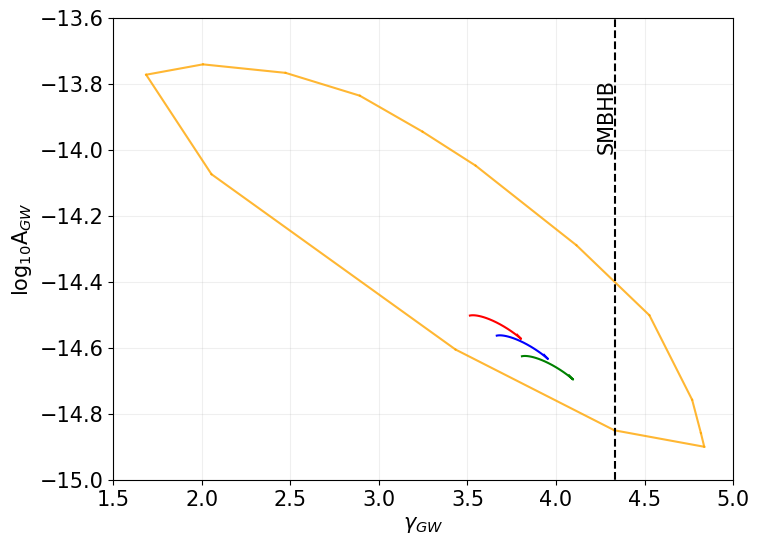

In [20]:
fs = 15
plt.rcParams.update({'font.size': fs})

plt.figure(figsize=(8,6))

i = 0
points = []
while i < len(A_arr):
    points += [[gamma_arr[i], A_arr[i]]]
    i+=1
points = np.array(points)
print(points)
hull = ConvexHull(points)

# plt.plot(points[:,0], points[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-', color = 'orange', alpha=.8)

plt.vlines(13/3, -16,-13, colors='black', linestyle='dashed')
plt.text(4.23, -14,'SMBHB', rotation='vertical')

H_inf_arr = [.47, 5.2, 5e1]
M_arr = [1.298, 1.251, 1.201]
color_arr = ['red', 'blue', 'green']
idx = 0
for M_GW in M_arr:
    H_inf = H_inf_arr[idx]
    M_GW *= H_inf
    freqs = np.logspace(np.log10(2e-9), np.log10(6e-8), num_freqs)
    tau_m = 1e10*(H_inf/1e14)**-2*tau_r
    Omega = h**2*omega_GW_full(freqs, M_GW, H_inf, tau_r, tau_m)
    Omega = np.log10(Omega)
    freqs = np.log10(freqs)
    for i in range(len(Omega)):
        grad = np.gradient(Omega, freqs)
        gamma_gw = 5 - grad
        A_gw = (Omega - grad*(freqs - np.log10(f_yr)) - np.log10(2*np.pi**2*f_yr**2/(3*H_0**2)) )/2
    plt.plot(gamma_gw,A_gw, color = color_arr[idx],label=r"$M_{GW}$ = "+f'{M_arr[idx]}'+r'$H_{inf}$' + r", $H_{inf}$ = "+f'{H_inf} GeV' + r", $\frac{\tau_m}{\tau_r} = 10^{10}H_{14}^{-2}$")
    idx+=1

plt.xlabel(r'$\gamma_{GW}$')
plt.ylabel(r'log$_{10}$A$_{GW}$')
plt.grid(alpha=.2)
plt.xlim(1.5,5)
plt.ylim(-15.0,-13.6)
plt.savefig('figs/fig4.pdf')
plt.show()

### Fig. 5

We plot figure 5, the energy density for the entire frequency range. 

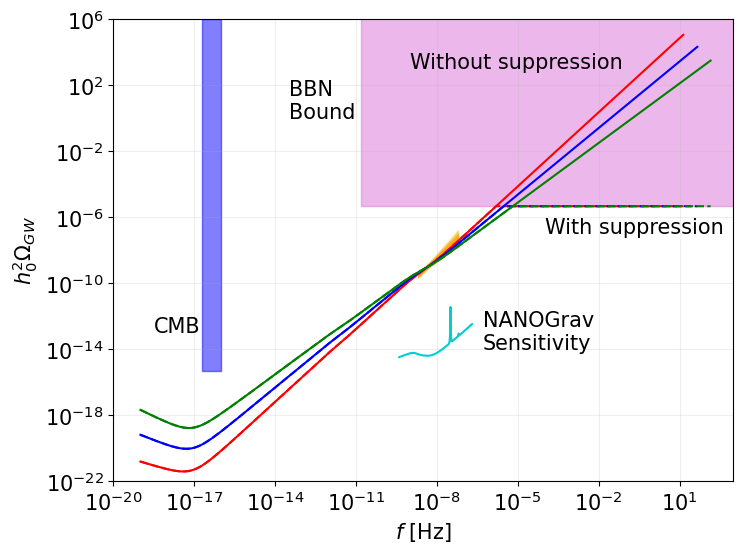

In [22]:
plt.figure(figsize=(8,6))

BBN = h**2*1e-5

CMB_f = np.logspace(-16.7, -16)
plt.fill_between(CMB_f,CMB_f*0+h**2*1e-15, CMB_f *
                 0 + 1e6, alpha=0.5, color='blue')
plt.text(10**-18.5, 1e-13, r"CMB", fontsize=15)

num_freqs = 30
freqs = np.logspace(np.log10(2e-9), np.log10(6e-8), num_freqs)

for ii in range(67):
    OMG_15[ii] = np.log10(h**2*omega_GW(freqs, A_arr[ii], gamma_arr[ii]))
plt.fill_between(freqs, 10**(OMG_15.mean(axis=0) - 1*OMG_15.std(axis=0)), 10**(OMG_15.mean(axis=0) + 1*OMG_15.std(axis=0)), color='orange', alpha=0.7)
plt.fill_between(freqs, 10**(OMG_15.mean(axis=0) - 2*OMG_15.std(axis=0)), 10**(OMG_15.mean(axis=0) + 2*OMG_15.std(axis=0)), color='orange', alpha=0.5)
plt.fill_between(freqs, 10**(OMG_15.mean(axis=0) - 3*OMG_15.std(axis=0)), 10**(OMG_15.mean(axis=0) + 3*OMG_15.std(axis=0)), color='orange', alpha=0.3)

num_freqs = 1000
tau_r = 5.494456683825391e-7  # calculated from equation (19)

H_inf_arr = [.47, 5.2, 5e1]
M_arr = [1.298, 1.251, 1.201]
color_arr = ['red', 'blue', 'green']
idx = 0
for M_GW in M_arr:
    H_inf = H_inf_arr[idx]
    M_GW *= H_inf
    f_UV = 2e8*(H_inf/1e14)**.5
    freqs = np.logspace(-19,np.log10(f_UV),num_freqs)
    tau_m = 1e10*(H_inf/1e14)**-2*tau_r
    Omega = np.where(h**2*omega_GW_full(freqs, M_GW, H_inf, tau_r, tau_m)< BBN, h**2*omega_GW_full(freqs, M_GW, H_inf, tau_r, tau_m), BBN)
    plt.plot(freqs, h**2*omega_GW_full(freqs, M_GW, H_inf, tau_r, tau_m),
         color=color_arr[idx], label=r"$M_{GW}$ = "+f'{M_arr[idx]}'+r'$H_{inf}$' + r", $H_{inf}$ = "+f'{H_inf} GeV' + r", $\frac{\tau_m}{\tau_r} = 10^{10}H_{14}^{-2}$")
    plt.plot(freqs, Omega, color=color_arr[idx], linestyle='dashed')
    idx+=1
plt.text(1e-4, 1e-7, r"With suppression", fontsize=15)
plt.text(1e-9, 1e3, r"Without suppression", fontsize=15)

BBN_f = np.logspace(np.log10(f_BBN), 9)
plt.fill_between((BBN_f), (BBN_f*0+h**2*1e-5),
                 (BBN_f * 0 + 1e10), alpha=0.5, color='orchid')
plt.text(10**-13.5, 1e0, "BBN\nBound", fontsize=15)

outfile = np.load('data/nanograv_sens_full.npz')

freq_NG = []
omega_GW_NG = []
idx = 0
with open('data/sensitivity_curves_NG15yr_fullPTA.txt', 'r') as file:
    for line in file:
        if idx != 0:
            elems = line.strip("\r\n").split(",")
            freq_NG.append(float(elems[0]))
            omega_GW_NG.append(float(elems[3]))
        idx +=1

f_nanoGrav = outfile['freqs']
nanoGrav_sens = outfile['sens']
plt.plot(f_nanoGrav, nanoGrav_sens, color='darkturquoise')

plt.text(5e-7, 1e-14, "NANOGrav\nSensitivity", fontsize=15)

plt.xlabel(r'$f$ [Hz]')
plt.ylabel(r'$h_0^2\Omega_{GW}$')
plt.xscale('log')
plt.yscale('log')
plt.grid(alpha=.2)
plt.xlim(1e-20,1e3)
plt.ylim(1e-22,1e6)
plt.savefig('figs/fig5.pdf')
plt.show()